# TP 5 - Expectation Maximization

## Ejercicios 1 y 2

* _Aplicar Expectation Maximization a una mixtura de Gausianas_
* _Comparar resultados inicializando los parámetros de diversas formas (puntualmente al azar y k-means)_

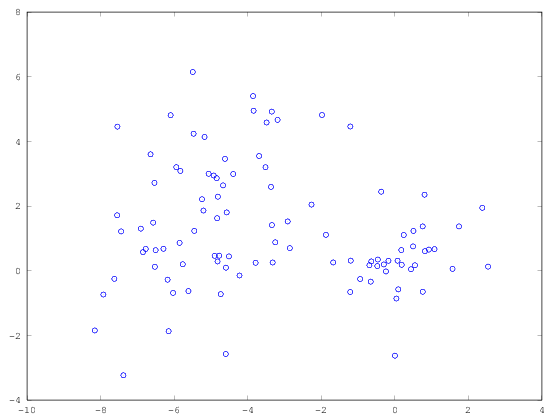

In [42]:
%% MUESTREO
NSAMPLES = 100;

% Modeling
model_mu_1 = [0 0];
model_sigma_1 = eye(2);
model_pi_1 = 0.3;

model_mu_2 = [-5 2];
model_sigma_2 = [2 0.5; 0.5 4];
model_pi_2 = 1 - model_pi_1;

% Sampling
%  Vemos la densidad de una mixtura de gaussianas como una densidad
%  condicional sobre una va latente (que depende de pi_1/pi_2)
D = [];
for i = 1:NSAMPLES
  if rand < model_pi_1
    D(i,:) = mvnrnd(model_mu_1, model_sigma_1);
  else
    D(i,:) = mvnrnd(model_mu_2, model_sigma_2);
  end
end

% Preview
xlabel('x'); ylabel('y'); zlabel('z');
scatter(D(:,1), D(:,2), 15);

In [39]:
%% EXPECTATION MAXIMIZATION
THRESHOLD = 10e-2;
K_MEANS = false;

% Initial parameters
% Notar que las muestras y las medias son vectores FILA,
% mientras que los vectores responsabilidades son COLUMNA
% (para operar facilmente con las muestras)
mu_1 = [1 1];
sigma_1 = eye(2);
pi_1 = 0.5;
resp_1 = [];

mu_2 = [-1 -1];
sigma_2 = eye(2);
pi_2 = 1 - pi_1;
resp_2 = [];

if K_MEANS
    while true
        mu_1_prev = mu_1;
        for i = 1:NSAMPLES
            resp_1(i,1) = norm(D(i,:) - mu_1) <= norm(D(i,:) - mu_2);
            resp_2(i,1) = !resp_1(i,1);
        end
        mu_1 = sum(D .* resp_1) / sum(resp_1);
        mu_2 = sum(D .* resp_2) / sum(resp_2);
        if all(abs(mu_1_prev - mu_1) < THRESHOLD)
            break;
        end
    end
end

% Clustering
muarr_1 = [];
muarr_2 = [];
while true
    % Save
    muarr_1 = [muarr_1; mu_1];
    muarr_2 = [muarr_2; mu_2];
    mu_1_prev = mu_1;

    % Expectation
    %  Recalculation of responsabilities (the probability for each sample to
    %  be on either class, which acts as soft assignments to clusters)
    for i = 1:NSAMPLES
        weight_1 = pi_1 * mvnpdf(D(i,:), mu_1, sigma_1);
        weight_2 = pi_2 * mvnpdf(D(i,:), mu_2, sigma_2);
        resp_1(i,1) = weight_1 / (weight_1 + weight_2);
        resp_2(i,1) = weight_2 / (weight_1 + weight_2);
    end
    
    % Maximization
    sumcell = @(cellarray) sum(cat(3, cellarray{:}), 3); % sums 1-dimensional cellarray
    arrayfun2cell = @(f, A) arrayfun(f, A, "UniformOutput", false); % general arrayfun
    summation = @(f, range) sumcell(arrayfun2cell(f, range)); % summation

    n1 = sum(resp_1);
    mu_1 = sum(D .* resp_1) / n1;
    sigma_1 = summation(@(i) resp_1(i) * (D(i,:) - mu_1)' * (D(i,:) - mu_1), 1:NSAMPLES) / n1;
    p1 = n1 / NSAMPLES;
    n2 = sum(resp_2);
    mu_2 = sum(D .* resp_2) / n2;
    sigma_2 = summation(@(i) resp_2(i) * (D(i,:) - mu_2)' * (D(i,:) - mu_2), 1:NSAMPLES) / n2;
    p2 = n2 / NSAMPLES;

    % Convergence
    if all(abs(mu_1_prev - mu_1) < THRESHOLD)
        muarr_1 = [muarr_1; mu_1];
        muarr_2 = [muarr_2; mu_2];
        break;
    end
end

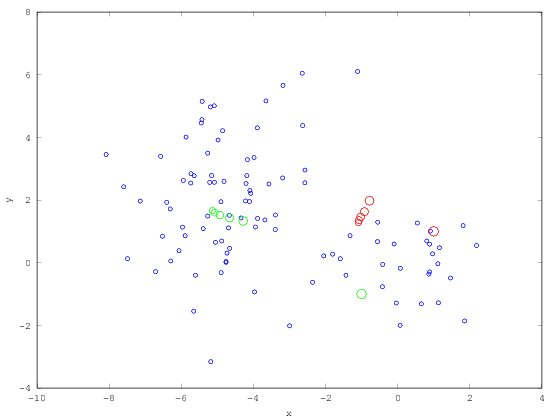

In [40]:
%% PLOT
hold on;

xlabel('x'); ylabel('y'); zlabel('z');
scatter(D(:,1), D(:,2), 12);

for i = 1:size(muarr_1, 1)
    scatter(muarr_1(i,1), muarr_1(i,2), 30 - 2*i, "r");
end
for i = 1:size(muarr_2, 1)
    scatter(muarr_2(i,1), muarr_2(i,2), 30 - 2*i, "g");
end